In [105]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt


### Download data

In [6]:
%%bash

wget -nc -O news-final.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/News_Final.csv 

wget -nc -O facebook-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/Facebook_Microsoft.csv
wget -nc -O googleplus-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/GooglePlus_Microsoft.csv
wget -nc -O linkedin-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/LinkedIn_Microsoft.csv


File ‘news-final.csv’ already there; not retrieving.
--2020-04-27 16:05:03--  http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/Facebook_Microsoft.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6776871 (6.5M) [application/x-httpd-php]
Saving to: ‘facebook-microsoft.csv’

     0K .......... .......... .......... .......... ..........  0%  344K 19s
    50K .......... .......... .......... .......... ..........  1%  639K 15s
   100K .......... .......... .......... .......... ..........  2%  255M 10s
   150K .......... .......... .......... .......... ..........  3%  334M 7s
   200K .......... .......... .......... .......... ..........  3%  724K 7s
   250K .......... .......... .......... .......... ..........  4%  275M 6s
   300K .......... .......... .......... .......... ..........  5%  742K 6s
   3

### Load data and set index

In [125]:
news = pd.read_csv('news-final.csv')
news = news[news['Topic']=='microsoft']
news = news.drop('Topic', 1)

news['IDLink'] = news['IDLink'].astype(int)
news = news.set_index('IDLink')


facebook = pd.read_csv('facebook-microsoft.csv')
facebook = facebook.set_index('IDLink')

google = pd.read_csv('googleplus-microsoft.csv')
google = google.set_index('IDLink')

linkedin = pd.read_csv('linkedin-microsoft.csv')
linkedin = linkedin.set_index('IDLink')


### Restrict to articles appearing on all 3 sites

In [126]:
posted_everywhere = news[['Facebook', 'GooglePlus', 'LinkedIn']].min(axis=1) > -1

news = news[posted_everywhere]

### Restrict to sources with at least 50 articles

In [127]:
greater_than_50 = (news['Source'].value_counts() > 50)

sources_50 = greater_than_50[greater_than_50 > 0].index

print("Number of sources with at least 50 articles: {}".format(greater_than_50.sum()))

news = news[news['Source'].isin(sources_50)]


Number of sources with at least 50 articles: 75


### Process dates

In [130]:
news.loc[:, 'PublishDate'] = pd.to_datetime(news['PublishDate'])

news.loc[:, 'Year'] = news['PublishDate'].dt.year
news.loc[:, 'Month'] = news['PublishDate'].dt.month
news.loc[:, 'DayOfWeek'] = news['PublishDate'].dt.weekday
news.loc[:, 'Hour'] = news['PublishDate'].dt.hour

In [134]:
import datetime

In [135]:
datetime.datetime?

In [139]:
news['PublishDate'].max()

may_1_2016 = datetime.datetime(2016, 5, 1)

news_historical = news[news['PublishDate'] <= may_1_2016]
news_new = news[news['PublishDate'] > may_1_2016]

In [142]:
news_new = news_new.drop(['Facebook', 'GooglePlus', 'LinkedIn'], 1)

In [143]:
news_new.to_csv('news-new.csv')

### Summary viz

In [86]:
news.head(2)

,Title,Headline,Source,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
IDLink,,,,,,,,,
311,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0
299,Microsoft’s OneDrive debacle shows its cloud c...,When Microsoft announced earlier this week tha...,Digital Trends via Yahoo! News,2015-11-08 12:15:00,-0.166139,-0.259052,6,0,1


**Year published**

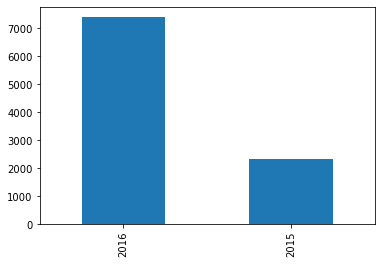

In [93]:
news['PublishDate'].dt.year.value_counts().plot.bar()

**Day of week**

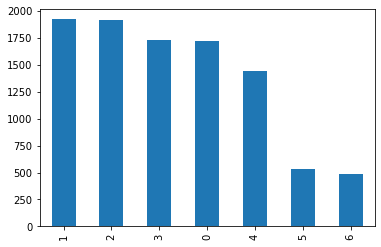

In [97]:
news['PublishDate'].dt.weekday.value_counts().plot.bar()

**Sentiment**

In [102]:
news['ones'] = 1

/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


news.plot.scatter('SentimentTitle', 'ones', alpha=0.1, figsize=(14, 0.5))

plt.axvline(news['SentimentTitle'].mean(), alpha = 0.4, ls='--')

## ML

In [149]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import base

In [172]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return X[self.col_names].values  #REMOVE

In [173]:
df = news_historical.drop(['PublishDate', 'Title', 'Headline'], 1)

In [177]:
source_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['Source'])),
    ('oh', OneHotEncoder())
]) 

source_pipe.fit_transform(df)

hour_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['Hour'])),
    ('oh', OneHotEncoder())
]) 

sentiment_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['SentimentTitle', 'SentimentHeadline']))
])

features = FeatureUnion([
    ('source', source_pipe),
    ('hour', hour_pipe),
    ('sentiment', sentiment_pipe)
])


features.fit_transform(df)

<7941x101 sparse matrix of type '<class 'numpy.float64'>'
	with 30127 stored elements in Compressed Sparse Row format>

In [182]:
facebook_model = Pipeline([
    ('features', features),
    ('model', LinearRegression())
])

facebook_model.fit(df, df['Facebook'])

google_model = Pipeline([
    ('features', features),
    ('model', LinearRegression())
])

google_model.fit(df, df['Facebook'])

linkedin_model = Pipeline([
    ('features', features),
    ('model', LinearRegression())
])

linkedin_model.fit(df, df['Facebook'])

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('source',
                                                 Pipeline(memory=None,
                                                          steps=[('cst',
                                                                  ColumnSelectTransformer(col_names=['Source'])),
                                                                 ('oh',
                                                                  OneHotEncoder(categories='auto',
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                                                                handle_unknown='error',
                                                                                sparse=True))],
                